# Visualize effectivity

Visualize the effectivity of a several policies in the containment of the spread of the virus.

### Imports and setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=4)
import csv

### Plot settings

In [2]:
show_policies = True
font_size = 18
show_legend = True

### Decide what to plot

In [3]:
# Parameters
R0 = 1.5 
symptomatics = 0.8
testing = 0 
delay = 2
memory = 7
eps_I = [0.2, 0.5, 0.8, 1]

# Model file
ext = '.csv'
model_folder = 'RESULTS_Model/'
model_basefile= 'critical_values_asympt_20_R0_%2.2f_sympt_%2.2f_testing_%2.2f_delay_%2.d_ni_%2.d_nt_%2.d'

# Simulation file
policy_folder = 'RESULTS/'
policy_basefile = 'eTs_epsI%1.1f_initialInfect%d_FilRSSI%d_FilDur%d_memCont%d_QuarTime%d'

# File where to save the figure
figure_name = 'figure_effectivity.pdf'

### Load the data

In [4]:
#%% Load the model predictions

# Size of the parameter grids
n_i = 10
n_t = 10

# Load the model predictions
model_file = model_folder + model_basefile % (R0, symptomatics, testing, delay, n_i, n_t) + ext
end_value = np.genfromtxt(model_file, delimiter=',')

# Generate the grid
ep_i = np.linspace(0, 1, n_i)    
ep_t = np.linspace(0, 1, n_t)    


#%% Define the policies

# Base definition of the policies
policy = {
    'P1': {'rssi': -73, 'duration': 30*60, 'color':'#2ca02c'},
    'P2': {'rssi': -80, 'duration': 20*60, 'color':'#ffd700'},
    'P3': {'rssi': -83, 'duration': 15*60, 'color':'#ff7f0e'},
    'P4': {'rssi': -87, 'duration': 10*60, 'color':'#ff0000'},
    'P5': {'rssi': -91, 'duration': 5*60, 'color':'#a52a2a'}    
}

# Add the common fields
for policy_name in policy.keys():
    policy[policy_name]['Y_i'] = 1
    policy[policy_name]['max_time_quar'] = 10
    policy[policy_name]['memory_contacts'] = memory
    policy[policy_name]['eps_I'] = eps_I
    # Initialize eps_T to zero
    policy[policy_name]['eps_T'] = [0 for _ in eps_I]
    
    
    
#%% Read the simulations and compute eps_T       

# Loop over the policies
for policy_name in policy.keys():
    # Loop over the values of eps_I
    for idx in range(len(policy[policy_name]['eps_I'])):
        # Set the correct filename
        filename = policy_folder + policy_basefile % (policy[policy_name]['eps_I'][idx], 
                                                      policy[policy_name]['Y_i'], 
                                                      policy[policy_name]['rssi'], 
                                                      policy[policy_name]['duration'], 
                                                      policy[policy_name]['memory_contacts'],
                                                      policy[policy_name]['max_time_quar'])
        
        filename += ext            

        # Read the file and compute eps_T
        with open(filename, 'r') as csvfile:
            reader = csv.reader(csvfile)
            eT_list = [np.array([float(e) for e in r]) for r in reader]
            eT_list = eT_list[:10]
            val = np.array([e.mean() for e in eT_list if e.shape[0] > 0]).mean()
            # Scale eps_T by the value of eps_I
            policy[policy_name]['eps_T'][idx] = (1 - val) * policy[policy_name]['eps_I'][idx]

### Plot  

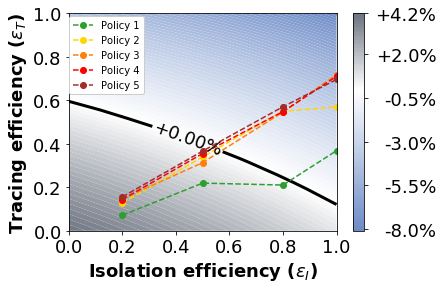

In [7]:
# Plot the contour lines of the model predictions
def round_to_base(x, base=0.5):
    '''round to the closest multiple of base'''
    return np.around(x / base) * base

l_min = np.ceil(np.min(end_value))
l_max = np.max(end_value)
n_l = 6
step = round_to_base((l_max - l_min) / (n_l - 1), base=0.5)

levels = np.arange(l_min, l_max, step)
if levels.shape[0] < n_l:
    levels = np.r_[levels, l_max]

    
from functions_continuous_model import MidpointNormalize

fig = plt.figure(1)
fig.clf()
ax = fig.gca()
xx, yy = np.meshgrid(ep_i, ep_t)

cmap = plt.get_cmap('bone_r').from_list('col', ['#6C8BC7', 'white', '#707784'])
alpha = 1

CS = ax.contourf(xx, yy, end_value.transpose(), 100, cmap=cmap,
                norm=MidpointNormalize(midpoint=0,vmin=np.min(end_value), vmax=np.max(end_value)),
                alpha=alpha,
                antialiased=True,
                )

cb = fig.colorbar(CS, ticks=levels, format='%+2.1f%%', alpha=alpha)
for t in cb.ax.get_yticklabels():
    t.set_horizontalalignment('right')   
    t.set_fontsize(font_size)
    t.set_x(7)

CS_z = ax.contour(xx, yy, end_value.transpose(), cmap='gist_gray', levels=np.array([0]), linewidths=3)
ax.clabel(CS_z, fmt='%+2.2f%%', inline=1, fontsize=font_size)
ax.set_xlabel(r'Isolation efficiency ($\epsilon_I$)', fontsize=font_size, fontweight='bold')
ax.set_ylabel(r'Tracing efficiency ($\epsilon_T$)', fontsize=font_size, fontweight='bold')
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(font_size) 
for tick in ax.yaxis.get_major_ticks():
   tick.label.set_fontsize(font_size) 

# Add the policies to the plot
if show_policies:
    for policy_name in policy.keys():
        ax.plot(policy[policy_name]['eps_I'], policy[policy_name]['eps_T'], 
                policy[policy_name]['color'], marker='o', linestyle='--')
    
    if show_legend:
        ax.legend(['Policy 1', 'Policy 2', 'Policy 3', 'Policy 4', 'Policy 5'], 
                  bbox_to_anchor=(0.3, 1.01),
                  fancybox=True, 
                  framealpha=1)


#%% Save the figure
plt.savefig(figure_name, bbox_inches='tight')